# 資料挖掘作業 2：吸菸預測模型

本專案透過多個機器學習模型的集成方法來預測吸菸狀態。我們使用了三種強大的梯度提升樹模型：XGBoost、LightGBM 和 CatBoost，並透過 Optuna 進行超參數優化，最後根據驗證集上的 AUC 得分進行加權集成。

## 1. 導入所需套件

首先導入所有需要使用的套件和函式庫。

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from datetime import datetime
import optuna
import shap
import time
import warnings

warnings.filterwarnings("ignore")
start_time = time.time()

## 2. 資料載入與探索

在這個部分，我們載入訓練和測試資料集，並進行初步的資料探索。

In [2]:
# 載入資料集
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# 顯示訓練集的基本資訊
print(f"訓練集形狀: {train.shape}")
print(f"測試集形狀: {test.shape}")
train.head()

訓練集形狀: (15000, 24)
測試集形狀: (10000, 23)


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,25.0,170.0,60.0,75.0,1.5,1.2,1.0,1.0,100.0,...,50.0,81.0,15.2,1.0,0.8,18.0,16.0,19.0,1.0,1.0
1,1,40.0,165.0,65.0,79.0,1.0,1.2,1.0,1.0,130.0,...,58.0,130.0,12.8,1.0,0.6,31.0,26.0,33.0,0.0,0.0
2,2,50.0,170.0,80.0,93.0,1.2,1.0,1.0,1.0,130.0,...,44.0,130.0,16.7,1.0,0.9,38.0,46.0,69.0,0.0,1.0
3,3,75.0,160.0,60.0,89.0,0.8,1.0,1.0,1.0,116.0,...,44.0,149.0,15.1,1.0,1.1,24.0,22.0,20.0,0.0,0.0
4,4,60.0,170.0,75.0,89.0,0.8,0.8,1.0,1.0,138.0,...,38.0,122.0,14.6,1.0,1.0,26.0,27.0,97.0,0.0,1.0


## 3. 資料前處理

資料前處理是機器學習流程中非常重要的一環。在這一部分，我們將執行以下步驟：
1. 合併訓練集和測試集以進行一致的特徵工程
2. 處理欄位名稱（替換空格為下劃線）
3. 辨識並分類特徵（類別型和數值型）
4. 進行缺失值處理和特徵轉換

In [3]:
# 合併訓練集和測試集以統一進行特徵處理
test['smoking'] = np.nan
data = pd.concat([train, test], ignore_index=True)

# 3. Feature Engineering

data['BMI'] = data['weight(kg)'] / (data['height(cm)'] / 100) ** 2
# data['LDL_to_HDL'] = data['LDL'] / (data['HDL'] + 1e-5)
# data['waist_BMI_ratio'] = data['waist(cm)'] / data['BMI']
# data['liver_mean'] = data[['AST', 'ALT', 'Gtp']].mean(axis=1)

# 定義類別型和數值型特徵
categorical_columns = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
numerical_columns = [col for col in data.columns if col not in categorical_columns + ['smoking', 'id']
                     and data[col].dtype in ['float64', 'int64']]

# 顯示分類後的特徵數量
print(f"類別型特徵數量: {len(categorical_columns)}")
print(f"數值型特徵數量: {len(numerical_columns)}")

類別型特徵數量: 4
數值型特徵數量: 19


### 3.1 缺失值處理與特徵轉換

我們使用以下方法處理資料：
1. 使用 SimpleImputer 填補缺失值（以中位數填補）
2. 應用 Yeo-Johnson 變換來處理偏態分佈
3. 使用 MinMaxScaler 將數值特徵縮放到相同範圍

In [4]:

# 應用 Power Transform 處理偏態分佈
power_transformer = PowerTransformer(method='yeo-johnson')
data[numerical_columns] = power_transformer.fit_transform(data[numerical_columns])

# 特徵縮放
scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

### 3.2 類別型特徵編碼與特徵工程

在這個部分，我們將：
1. 對類別型特徵進行 One-Hot 編碼
2. 應用 KMeans 聚類作為特徵工程的一部分，創建新的聚類特徵

In [5]:
categorical_columns

['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']

In [6]:
# One-Hot 編碼
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(data[categorical_columns])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_columns), index=data.index)
data = data.drop(columns=categorical_columns)
data = pd.concat([data, encoded_df], axis=1)

In [7]:

# 使用 KMeans 進行聚類特徵工程
kmeans = KMeans(n_clusters=5, random_state=42)
data['kmeans_cluster'] = kmeans.fit_predict(data[numerical_columns])

# 檢視特徵工程後的資料
print(f"處理後的特徵數量: {data.shape[1]}")

Exception in thread Thread-3 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xaa in position 24: invalid start byte
  File "c:\Users\ian32\Downloads\ncku-cs-data-mining-homework-2\.conda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 262, in _

處理後的特徵數量: 29


In [8]:
print(data.columns)

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar',
       'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin',
       'serum creatinine', 'AST', 'ALT', 'Gtp', 'smoking', 'BMI',
       'hearing(left)_2.0', 'hearing(right)_2.0', 'Urine protein_2.0',
       'Urine protein_3.0', 'Urine protein_4.0', 'Urine protein_5.0',
       'dental caries_1.0', 'kmeans_cluster'],
      dtype='object')


## 4. 資料分割

將資料分割為訓練集、驗證集和測試集。這是模型訓練和評估的重要步驟。

In [9]:
# 定義需要省略的特徵
features_to_drop = ['hearing(left)_2.0', 'hearing(right)_2.0']  # 替換為你想刪除的特徵名稱

# 合併訓練集和測試集後，刪除不需要的特徵
data = data.drop(columns=features_to_drop, errors='ignore')

# 分割資料
train_length = len(train)
X = data.iloc[:train_length].drop(columns=['smoking', 'id'], errors='ignore')
X_test = data.iloc[train_length:].drop(columns=['smoking', 'id'], errors='ignore')
y = data.iloc[:train_length]['smoking'].astype(int)

# 分割訓練集和驗證集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# 檢查刪除後的數據集形狀
print(f"訓練集形狀: {X_train.shape}")
print(f"驗證集形狀: {X_val.shape}")
print(f"測試集形狀: {X_test.shape}")

訓練集形狀: (13500, 25)
驗證集形狀: (1500, 25)
測試集形狀: (10000, 25)


## 5. 模型超參數優化與訓練

在這個部分，我們將使用 Optuna 來為三種不同的梯度提升樹模型尋找最佳的超參數。超參數優化是提高模型性能的關鍵步驟。

### 5.1 XGBoost 模型優化與訓練

XGBoost 是一種高效能的梯度提升樹實現，特別適合結構化/表格式資料。

[I 2025-04-14 16:04:35,809] A new study created in memory with name: no-name-a06b63ce-af4d-4d2a-92ec-07d3a926b090
[I 2025-04-14 16:04:49,846] Trial 0 finished with value: 0.8855650139089531 and parameters: {'n_estimators': 290, 'max_depth': 3, 'learning_rate': 0.07187971899926339, 'subsample': 0.6731189710440456, 'colsample_bytree': 0.6537102542261138, 'min_child_weight': 7, 'gamma': 1.3337073758497586, 'reg_alpha': 3.1814391448511623, 'reg_lambda': 3.7482731484857297}. Best is trial 0 with value: 0.8855650139089531.
[I 2025-04-14 16:05:33,783] Trial 1 finished with value: 0.881898207953772 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.06344244430671689, 'subsample': 0.9296763221699328, 'colsample_bytree': 0.9432516984054787, 'min_child_weight': 9, 'gamma': 0.12258545655842168, 'reg_alpha': 3.390788145874258, 'reg_lambda': 3.6231198791528025}. Best is trial 0 with value: 0.8855650139089531.
[I 2025-04-14 16:05:47,300] Trial 2 finished with value: 0.8829726715

Best XGBoost Parameters:
{'n_estimators': 312, 'max_depth': 3, 'learning_rate': 0.07588778198365785, 'subsample': 0.7709215593459432, 'colsample_bytree': 0.6567424985040989, 'min_child_weight': 10, 'gamma': 2.215566734825111, 'reg_alpha': 2.7887258939620803, 'reg_lambda': 3.9652636149995013}
Best AUC: 0.8858


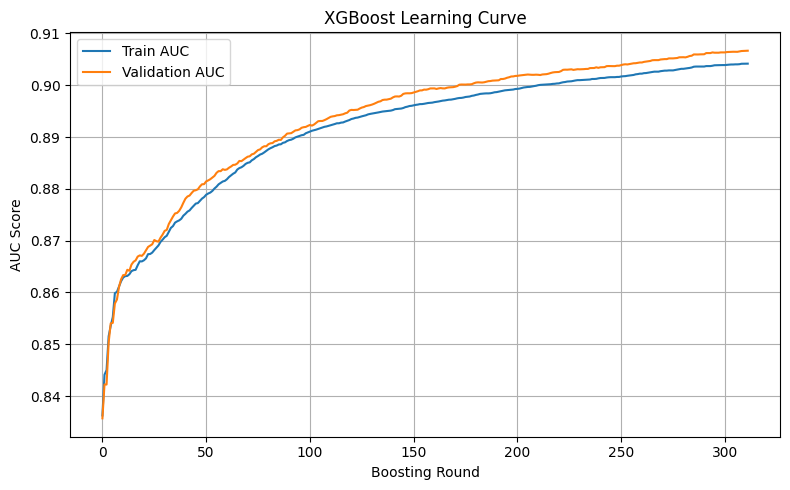

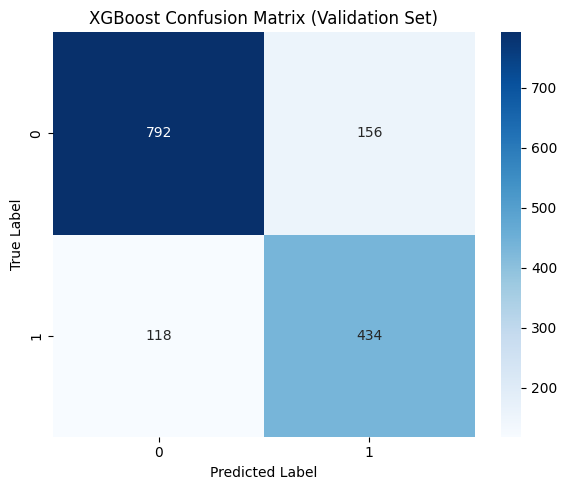

<Figure size 1000x600 with 0 Axes>

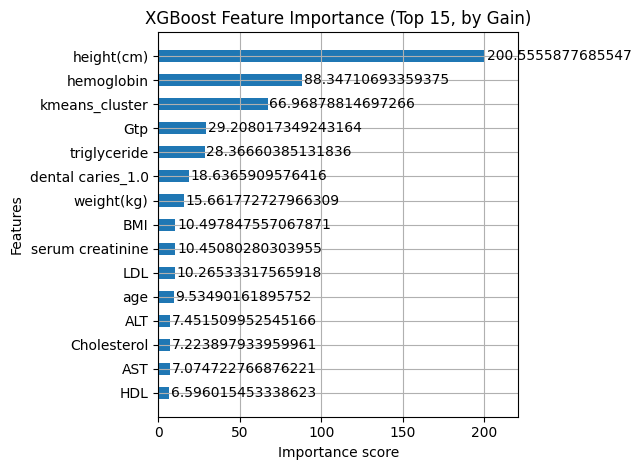

 99%|===================| 1491/1500 [00:12<00:00]        

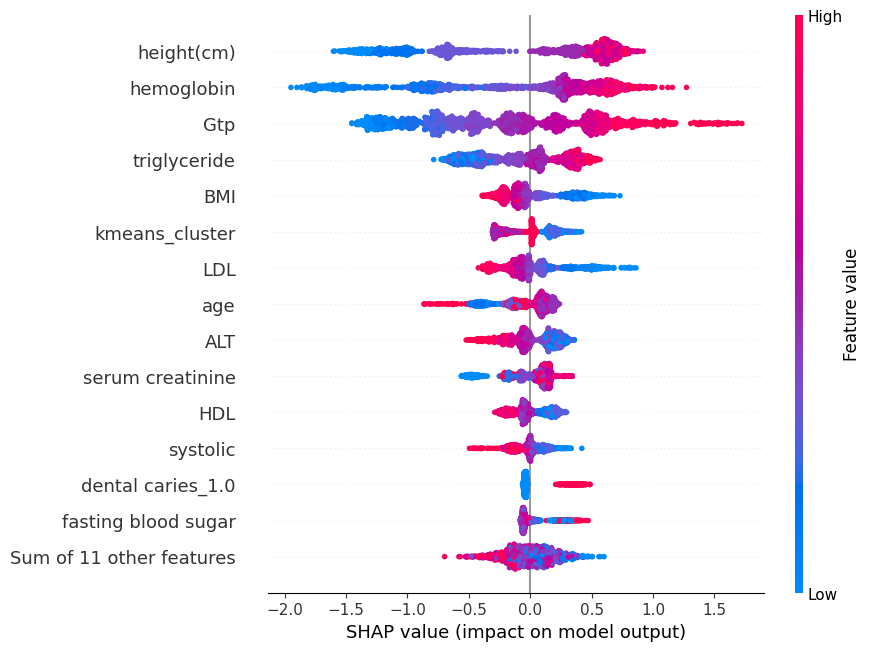

In [40]:
import optuna
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#-----------------------------
# 1. Define Optuna objective function
#-----------------------------
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'tree_method': 'hist',
        'grow_policy': 'lossguide',
        'device': 'cuda',
        'eval_metric': 'auc'
    }
    
    aucs = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in skf.split(X, y):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_fold_train, 
            y_fold_train, 
            eval_set=[(X_fold_val, y_fold_val)],
            verbose=False
        )
        
        preds = model.predict_proba(X_fold_val)[:, 1]
        aucs.append(roc_auc_score(y_fold_val, preds))
    
    mean_auc = np.mean(aucs)
    trial.set_user_attr("params", params)
    trial.set_user_attr("mean_auc", mean_auc)
    return mean_auc

#-----------------------------
# 2. Run Optuna optimization
#-----------------------------
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

print("Best XGBoost Parameters:")
print(study_xgb.best_params)
print(f"Best AUC: {study_xgb.best_value:.4f}")

#-----------------------------
# 3. Train final model using best parameters
#-----------------------------
best_xgb = xgb.XGBClassifier(
    **study_xgb.best_params,
    tree_method='hist',
    device='cuda',
    eval_metric='auc',
    use_label_encoder=False
)

best_xgb.fit(
    X,
    y,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

#-----------------------------
# 4. Draw learning curve
#-----------------------------
results = best_xgb.evals_result()

plt.figure(figsize=(8, 5))
plt.plot(results['validation_0']['auc'], label='Train AUC')
plt.plot(results['validation_1']['auc'], label='Validation AUC')
plt.xlabel('Boosting Round')
plt.ylabel('AUC Score')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------
# 5. Predict on validation set & draw confusion matrix
#-----------------------------
xgb_preds = best_xgb.predict_proba(X_val)
xgb_labels = np.argmax(xgb_preds, axis=1)
cm = confusion_matrix(y_val, xgb_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

#-----------------------------
# 6. Feature Importance Plot
#-----------------------------
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_xgb, max_num_features=15, importance_type='gain', height=0.5)
plt.title("XGBoost Feature Importance (Top 15, by Gain)")
plt.tight_layout()
plt.show()

#-----------------------------
# 7. SHAP Analysis (Global Explanation)
#-----------------------------
explainer = shap.Explainer(best_xgb, X_train, feature_names=X_train.columns)
shap_values = explainer(X_val)

# SHAP Summary Plot
shap.plots.beeswarm(shap_values, max_display=15)

# (Optional) Individual force plot for first prediction
# shap.plots.force(shap_values[0])  # <- 可視化個別樣本，Jupyter 內建支援互動


### 5.2 LightGBM 模型優化與訓練

LightGBM 是一個高效、低記憶體佔用的梯度提升框架，使用基於直方圖的分割尋找策略，適合大型資料集。

In [41]:
import optuna
import numpy as np
from lightgbm import LGBMClassifier
import lightgbm as lgb
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#-----------------------------
# 1. Define Optuna Objective Function
#-----------------------------
def objective_lgb(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'device_type': 'gpu',
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0)
    }

    aucs = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X, y):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        model = LGBMClassifier(**params)
        model.fit(
            X_fold_train,
            y_fold_train,
            eval_set=[(X_fold_val, y_fold_val)],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(30)]
        )

        preds = model.predict_proba(X_fold_val)[:, 1]
        aucs.append(roc_auc_score(y_fold_val, preds))

    mean_auc = np.mean(aucs)
    trial.set_user_attr("params", params)
    trial.set_user_attr("mean_auc", mean_auc)
    return mean_auc

#-----------------------------
# 2. Run Optuna Optimization
#-----------------------------
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)

print("Best LightGBM Parameters:")
print(study_lgb.best_params)
print(f"Best AUC: {study_lgb.best_value:.4f}")

#-----------------------------
# 3. Train Final Model with Best Parameters
#-----------------------------
best_lgb = LGBMClassifier(
    **study_lgb.best_params,
    verbosity=-1,
    device_type='gpu'
)

best_lgb.fit(
    X, y,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(30)]
)



[I 2025-04-14 16:13:35,522] A new study created in memory with name: no-name-f6e2da4f-3237-4d32-9a14-53cde2b92de9


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[76]	valid_0's auc: 0.882938
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[153]	valid_0's auc: 0.885921
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.882194
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[110]	valid_0's auc: 0.892605
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:14:09,920] Trial 0 finished with value: 0.884949056220824 and parameters: {'n_estimators': 327, 'learning_rate': 0.11292156295134048, 'num_leaves': 145, 'max_depth': 6, 'min_child_samples': 47, 'subsample': 0.9639441977966156, 'colsample_bytree': 0.7412705376643542, 'reg_alpha': 1.6338622242091172, 'reg_lambda': 0.6491394902193581}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[90]	valid_0's auc: 0.881086
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.883669
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[96]	valid_0's auc: 0.885033
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.87918
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.891444
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:14:31,259] Trial 1 finished with value: 0.8840508602060673 and parameters: {'n_estimators': 396, 'learning_rate': 0.1634636489244227, 'num_leaves': 133, 'max_depth': 6, 'min_child_samples': 94, 'subsample': 0.607093730772699, 'colsample_bytree': 0.8721118071366915, 'reg_alpha': 1.5872826615578446, 'reg_lambda': 2.763377679673058}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[46]	valid_0's auc: 0.880928
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[205]	valid_0's auc: 0.88175
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[201]	valid_0's auc: 0.88243
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[205]	valid_0's auc: 0.877734
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[205]	valid_0's auc: 0.891116
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:14:58,073] Trial 2 finished with value: 0.8826283981422893 and parameters: {'n_estimators': 205, 'learning_rate': 0.05160020550091688, 'num_leaves': 113, 'max_depth': 3, 'min_child_samples': 42, 'subsample': 0.8307658175898914, 'colsample_bytree': 0.6464417174079528, 'reg_alpha': 1.9701989464259784, 'reg_lambda': 2.2539074996938204}. Best is trial 0 with value: 0.884949056220824.


Did not meet early stopping. Best iteration is:
[204]	valid_0's auc: 0.880112
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[73]	valid_0's auc: 0.882266
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's auc: 0.883683
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.878708
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.889339
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:15:26,040] Trial 3 finished with value: 0.8824385200396376 and parameters: {'n_estimators': 463, 'learning_rate': 0.18560408104777804, 'num_leaves': 54, 'max_depth': 8, 'min_child_samples': 47, 'subsample': 0.643971401159271, 'colsample_bytree': 0.7573485528136986, 'reg_alpha': 2.4815748535944953, 'reg_lambda': 2.7961974517653654}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[35]	valid_0's auc: 0.878196
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.882511
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[80]	valid_0's auc: 0.884756
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[117]	valid_0's auc: 0.881294
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's auc: 0.890071
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:15:50,358] Trial 4 finished with value: 0.8841422653088026 and parameters: {'n_estimators': 247, 'learning_rate': 0.17401136418700203, 'num_leaves': 91, 'max_depth': 5, 'min_child_samples': 96, 'subsample': 0.8069317234685365, 'colsample_bytree': 0.6611144413954121, 'reg_alpha': 0.22709573381881343, 'reg_lambda': 2.8156914308881005}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[53]	valid_0's auc: 0.88208
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[117]	valid_0's auc: 0.884523
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[202]	valid_0's auc: 0.884373
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[116]	valid_0's auc: 0.879535
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[171]	valid_0's auc: 0.892357
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:16:48,721] Trial 5 finished with value: 0.884607695889397 and parameters: {'n_estimators': 393, 'learning_rate': 0.05184968984892402, 'num_leaves': 31, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.7203878828099279, 'colsample_bytree': 0.6316341199285729, 'reg_alpha': 0.9111662871726489, 'reg_lambda': 3.817499827416118}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[163]	valid_0's auc: 0.88225
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.884806
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's auc: 0.883
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.878547
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.890262
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:17:12,224] Trial 6 finished with value: 0.8837153261142087 and parameters: {'n_estimators': 274, 'learning_rate': 0.15806402562530825, 'num_leaves': 137, 'max_depth': 7, 'min_child_samples': 66, 'subsample': 0.9902909603176335, 'colsample_bytree': 0.6676448565684504, 'reg_alpha': 1.9937465594421249, 'reg_lambda': 0.6812142534016108}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[55]	valid_0's auc: 0.881962
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[175]	valid_0's auc: 0.884446
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[264]	valid_0's auc: 0.885871
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[192]	valid_0's auc: 0.880496
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[120]	valid_0's auc: 0.891047
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:17:56,202] Trial 7 finished with value: 0.884911042395444 and parameters: {'n_estimators': 366, 'learning_rate': 0.07101671452902972, 'num_leaves': 23, 'max_depth': 5, 'min_child_samples': 90, 'subsample': 0.8542053131759044, 'colsample_bytree': 0.8794447543091437, 'reg_alpha': 3.2860966259702917, 'reg_lambda': 1.3543007901823607}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[190]	valid_0's auc: 0.882695
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[212]	valid_0's auc: 0.883476
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[216]	valid_0's auc: 0.883414
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[216]	valid_0's auc: 0.880427
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[205]	valid_0's auc: 0.892376
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:18:28,779] Trial 8 finished with value: 0.8840839074009956 and parameters: {'n_estimators': 216, 'learning_rate': 0.06100148336578981, 'num_leaves': 32, 'max_depth': 3, 'min_child_samples': 33, 'subsample': 0.7444433964227156, 'colsample_bytree': 0.7611678420380222, 'reg_alpha': 2.8106611847741365, 'reg_lambda': 1.2286004328570477}. Best is trial 0 with value: 0.884949056220824.


Did not meet early stopping. Best iteration is:
[216]	valid_0's auc: 0.880726
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[122]	valid_0's auc: 0.883975
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[246]	valid_0's auc: 0.886386
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[167]	valid_0's auc: 0.879643
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[185]	valid_0's auc: 0.892814
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:19:04,041] Trial 9 finished with value: 0.8848044508649817 and parameters: {'n_estimators': 374, 'learning_rate': 0.1419512158726317, 'num_leaves': 141, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.6298208636427337, 'colsample_bytree': 0.9060484583054628, 'reg_alpha': 3.0451899751413265, 'reg_lambda': 4.767819484057396}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[210]	valid_0's auc: 0.881204
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[76]	valid_0's auc: 0.883521
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[73]	valid_0's auc: 0.883062
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.877274
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.888903
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:19:44,722] Trial 10 finished with value: 0.8825779677407801 and parameters: {'n_estimators': 312, 'learning_rate': 0.10973352742367454, 'num_leaves': 81, 'max_depth': 10, 'min_child_samples': 61, 'subsample': 0.9808252657772732, 'colsample_bytree': 0.9865867157446131, 'reg_alpha': 4.87876334561099, 'reg_lambda': 0.0027061034216728785}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[75]	valid_0's auc: 0.880131
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[178]	valid_0's auc: 0.885539
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[171]	valid_0's auc: 0.885747
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[97]	valid_0's auc: 0.87872
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[79]	valid_0's auc: 0.890712
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:20:13,783] Trial 11 finished with value: 0.8846232643656204 and parameters: {'n_estimators': 329, 'learning_rate': 0.09361352894195367, 'num_leaves': 69, 'max_depth': 5, 'min_child_samples': 77, 'subsample': 0.892512564330103, 'colsample_bytree': 0.8427790793428954, 'reg_alpha': 3.9237355723699667, 'reg_lambda': 1.553578449310541}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[164]	valid_0's auc: 0.882399
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[447]	valid_0's auc: 0.881502
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[445]	valid_0's auc: 0.880579
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[446]	valid_0's auc: 0.876604
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[447]	valid_0's auc: 0.889212
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:21:48,183] Trial 12 finished with value: 0.8812893181628242 and parameters: {'n_estimators': 447, 'learning_rate': 0.010668972550941916, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 79, 'subsample': 0.8806938116634863, 'colsample_bytree': 0.7471382818295076, 'reg_alpha': 3.623552476274628, 'reg_lambda': 0.05356348852479709}. Best is trial 0 with value: 0.884949056220824.


Did not meet early stopping. Best iteration is:
[447]	valid_0's auc: 0.87855
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[106]	valid_0's auc: 0.884511
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[116]	valid_0's auc: 0.885624
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[114]	valid_0's auc: 0.880671
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.890003
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:22:13,978] Trial 13 finished with value: 0.884002722095536 and parameters: {'n_estimators': 310, 'learning_rate': 0.11218696090171561, 'num_leaves': 58, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.9204023235071006, 'colsample_bytree': 0.940465541955766, 'reg_alpha': 1.2040413754360042, 'reg_lambda': 1.416103405743501}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[73]	valid_0's auc: 0.879205
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[219]	valid_0's auc: 0.885257
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[215]	valid_0's auc: 0.886169
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[180]	valid_0's auc: 0.880515
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[222]	valid_0's auc: 0.891464
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:23:02,556] Trial 14 finished with value: 0.8848595613605703 and parameters: {'n_estimators': 414, 'learning_rate': 0.08042565507381508, 'num_leaves': 21, 'max_depth': 4, 'min_child_samples': 57, 'subsample': 0.925767514535454, 'colsample_bytree': 0.8173551300570487, 'reg_alpha': 3.779295273314851, 'reg_lambda': 0.7771401744814005}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[265]	valid_0's auc: 0.880893
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.88307
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.8835
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[79]	valid_0's auc: 0.879701
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[78]	valid_0's auc: 0.890651
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:23:35,150] Trial 15 finished with value: 0.8834448357788416 and parameters: {'n_estimators': 498, 'learning_rate': 0.13082226316438034, 'num_leaves': 112, 'max_depth': 7, 'min_child_samples': 82, 'subsample': 0.8639109935544359, 'colsample_bytree': 0.7298242305676877, 'reg_alpha': 4.675872798926747, 'reg_lambda': 1.6908868484656263}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[90]	valid_0's auc: 0.880303
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[164]	valid_0's auc: 0.883784
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[245]	valid_0's auc: 0.883983
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[270]	valid_0's auc: 0.880406
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[214]	valid_0's auc: 0.891021
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:25:32,771] Trial 16 finished with value: 0.884297854558913 and parameters: {'n_estimators': 353, 'learning_rate': 0.02396598323405169, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 34, 'subsample': 0.7580627611803459, 'colsample_bytree': 0.8026828348924218, 'reg_alpha': 0.02670688302613211, 'reg_lambda': 0.6756965230013459}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[239]	valid_0's auc: 0.882295
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[216]	valid_0's auc: 0.885751
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[190]	valid_0's auc: 0.884683
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[177]	valid_0's auc: 0.879076
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[208]	valid_0's auc: 0.89246
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:26:20,614] Trial 17 finished with value: 0.8849133346864217 and parameters: {'n_estimators': 277, 'learning_rate': 0.07569800694718595, 'num_leaves': 149, 'max_depth': 4, 'min_child_samples': 67, 'subsample': 0.9551176273538589, 'colsample_bytree': 0.7100276528152574, 'reg_alpha': 3.062626749826889, 'reg_lambda': 2.163764798775647}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[186]	valid_0's auc: 0.882597
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[116]	valid_0's auc: 0.885284
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[176]	valid_0's auc: 0.885885
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[120]	valid_0's auc: 0.880887
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[86]	valid_0's auc: 0.890218
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:26:49,182] Trial 18 finished with value: 0.884883630415836 and parameters: {'n_estimators': 268, 'learning_rate': 0.12792749417851268, 'num_leaves': 148, 'max_depth': 4, 'min_child_samples': 69, 'subsample': 0.9586062909039945, 'colsample_bytree': 0.7066035633330953, 'reg_alpha': 2.361306078603849, 'reg_lambda': 2.1421179675311053}. Best is trial 0 with value: 0.884949056220824.


Early stopping, best iteration is:
[191]	valid_0's auc: 0.882144
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[243]	valid_0's auc: 0.884787
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[255]	valid_0's auc: 0.885456
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[207]	valid_0's auc: 0.881365
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[195]	valid_0's auc: 0.891733
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:27:45,222] Trial 19 finished with value: 0.8849553600210127 and parameters: {'n_estimators': 292, 'learning_rate': 0.08581578949811132, 'num_leaves': 125, 'max_depth': 4, 'min_child_samples': 50, 'subsample': 0.9428109525034285, 'colsample_bytree': 0.6857983489338844, 'reg_alpha': 0.7851699425709835, 'reg_lambda': 3.2347362693345643}. Best is trial 19 with value: 0.8849553600210127.


Early stopping, best iteration is:
[195]	valid_0's auc: 0.881436
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[89]	valid_0's auc: 0.88349
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[132]	valid_0's auc: 0.885354
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[102]	valid_0's auc: 0.880519
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.890983
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:28:23,573] Trial 20 finished with value: 0.8845560238302751 and parameters: {'n_estimators': 332, 'learning_rate': 0.09902375071401864, 'num_leaves': 124, 'max_depth': 6, 'min_child_samples': 49, 'subsample': 0.9188057011003912, 'colsample_bytree': 0.618971739955267, 'reg_alpha': 0.5804796642310478, 'reg_lambda': 3.4502821644535935}. Best is trial 19 with value: 0.8849553600210127.


Early stopping, best iteration is:
[108]	valid_0's auc: 0.882433
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[241]	valid_0's auc: 0.885069
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[285]	valid_0's auc: 0.886129
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[223]	valid_0's auc: 0.881511
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[151]	valid_0's auc: 0.891745
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:29:17,447] Trial 21 finished with value: 0.8852858319702956 and parameters: {'n_estimators': 286, 'learning_rate': 0.08434142741678588, 'num_leaves': 150, 'max_depth': 4, 'min_child_samples': 55, 'subsample': 0.9499244096081294, 'colsample_bytree': 0.6881098297067013, 'reg_alpha': 1.4258916567982862, 'reg_lambda': 3.5193414628811945}. Best is trial 21 with value: 0.8852858319702956.


Early stopping, best iteration is:
[171]	valid_0's auc: 0.881975
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[197]	valid_0's auc: 0.884205
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[188]	valid_0's auc: 0.885187
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[185]	valid_0's auc: 0.881493
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[117]	valid_0's auc: 0.892024
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:30:05,398] Trial 22 finished with value: 0.8846694922336704 and parameters: {'n_estimators': 300, 'learning_rate': 0.08970168547606003, 'num_leaves': 124, 'max_depth': 4, 'min_child_samples': 40, 'subsample': 0.9948779799585279, 'colsample_bytree': 0.6903448355400864, 'reg_alpha': 1.3633938520447544, 'reg_lambda': 3.6286375374376667}. Best is trial 21 with value: 0.8852858319702956.


Early stopping, best iteration is:
[87]	valid_0's auc: 0.880437
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[190]	valid_0's auc: 0.88433
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[158]	valid_0's auc: 0.885739
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[190]	valid_0's auc: 0.882432
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[113]	valid_0's auc: 0.891269
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:30:49,372] Trial 23 finished with value: 0.8848152437350016 and parameters: {'n_estimators': 244, 'learning_rate': 0.11837437213049916, 'num_leaves': 127, 'max_depth': 4, 'min_child_samples': 54, 'subsample': 0.9532550967932495, 'colsample_bytree': 0.607838634472652, 'reg_alpha': 0.768259237495202, 'reg_lambda': 4.119979568716453}. Best is trial 21 with value: 0.8852858319702956.


Early stopping, best iteration is:
[94]	valid_0's auc: 0.880307
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[287]	valid_0's auc: 0.884668
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[294]	valid_0's auc: 0.885129
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[297]	valid_0's auc: 0.881171
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[275]	valid_0's auc: 0.892168
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:32:11,307] Trial 24 finished with value: 0.8848802874914934 and parameters: {'n_estimators': 298, 'learning_rate': 0.04021729172858203, 'num_leaves': 149, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.9025940169522115, 'colsample_bytree': 0.7859491138946411, 'reg_alpha': 1.8129533923148486, 'reg_lambda': 3.189594470038595}. Best is trial 21 with value: 0.8852858319702956.


Did not meet early stopping. Best iteration is:
[298]	valid_0's auc: 0.881266
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[277]	valid_0's auc: 0.884923
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[305]	valid_0's auc: 0.886376
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[253]	valid_0's auc: 0.881692
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[210]	valid_0's auc: 0.891968
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:32:47,977] Trial 25 finished with value: 0.8854908009885504 and parameters: {'n_estimators': 334, 'learning_rate': 0.08653796378841633, 'num_leaves': 105, 'max_depth': 3, 'min_child_samples': 48, 'subsample': 0.9455455498501087, 'colsample_bytree': 0.6826916172295672, 'reg_alpha': 1.126985546078804, 'reg_lambda': 4.348091542179647}. Best is trial 25 with value: 0.8854908009885504.


Early stopping, best iteration is:
[228]	valid_0's auc: 0.882495
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[243]	valid_0's auc: 0.884291
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[241]	valid_0's auc: 0.88501
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[242]	valid_0's auc: 0.881063
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[187]	valid_0's auc: 0.892372
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:33:21,728] Trial 26 finished with value: 0.8848608985303074 and parameters: {'n_estimators': 243, 'learning_rate': 0.08517441776001027, 'num_leaves': 98, 'max_depth': 3, 'min_child_samples': 59, 'subsample': 0.9396664569852301, 'colsample_bytree': 0.6822985591291019, 'reg_alpha': 1.1001367421778767, 'reg_lambda': 4.373745191672318}. Best is trial 25 with value: 0.8854908009885504.


Did not meet early stopping. Best iteration is:
[215]	valid_0's auc: 0.881569
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[344]	valid_0's auc: 0.885408
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[345]	valid_0's auc: 0.885723
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[343]	valid_0's auc: 0.880645
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[197]	valid_0's auc: 0.891765
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:34:00,057] Trial 27 finished with value: 0.8850552657027903 and parameters: {'n_estimators': 345, 'learning_rate': 0.0650847322886755, 'num_leaves': 115, 'max_depth': 3, 'min_child_samples': 40, 'subsample': 0.8494306508280888, 'colsample_bytree': 0.6011110163912556, 'reg_alpha': 0.5273071692456205, 'reg_lambda': 4.864020902864855}. Best is trial 25 with value: 0.8854908009885504.


Early stopping, best iteration is:
[285]	valid_0's auc: 0.881736
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[342]	valid_0's auc: 0.883355
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[342]	valid_0's auc: 0.88365
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[339]	valid_0's auc: 0.878883
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[337]	valid_0's auc: 0.891176
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[342]	valid_0's auc: 0.880489


[I 2025-04-14 16:35:14,279] Trial 28 finished with value: 0.8835106436323261 and parameters: {'n_estimators': 342, 'learning_rate': 0.0363869846442325, 'num_leaves': 81, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.794496658214986, 'colsample_bytree': 0.6000960584836449, 'reg_alpha': 0.40444505703609757, 'reg_lambda': 4.702706335488718}. Best is trial 25 with value: 0.8854908009885504.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[232]	valid_0's auc: 0.883787
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[354]	valid_0's auc: 0.885065
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[362]	valid_0's auc: 0.881105
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[286]	valid_0's auc: 0.892384
Training until validation scores don't improve for 30 rounds


[I 2025-04-14 16:36:01,181] Trial 29 finished with value: 0.8847180123926981 and parameters: {'n_estimators': 362, 'learning_rate': 0.06294677190006907, 'num_leaves': 115, 'max_depth': 3, 'min_child_samples': 39, 'subsample': 0.8314460135710143, 'colsample_bytree': 0.6432521637411812, 'reg_alpha': 1.3762500623221836, 'reg_lambda': 4.992881008397789}. Best is trial 25 with value: 0.8854908009885504.


Early stopping, best iteration is:
[302]	valid_0's auc: 0.88125
Best LightGBM Parameters:
{'n_estimators': 334, 'learning_rate': 0.08653796378841633, 'num_leaves': 105, 'max_depth': 3, 'min_child_samples': 48, 'subsample': 0.9455455498501087, 'colsample_bytree': 0.6826916172295672, 'reg_alpha': 1.126985546078804, 'reg_lambda': 4.348091542179647}
Best AUC: 0.8855
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[334]	valid_0's auc: 0.910609	valid_0's binary_logloss: 0.36418	valid_1's auc: 0.913628	valid_1's binary_logloss: 0.35978


KeyError: 'training'

<Figure size 800x500 with 0 Axes>

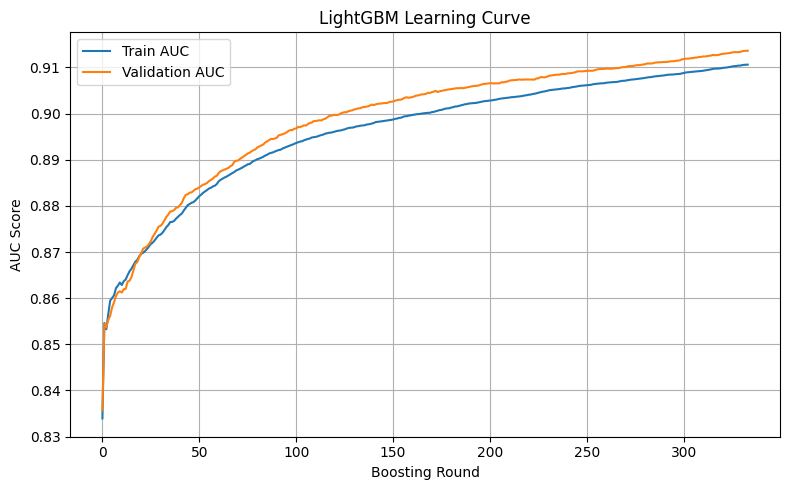

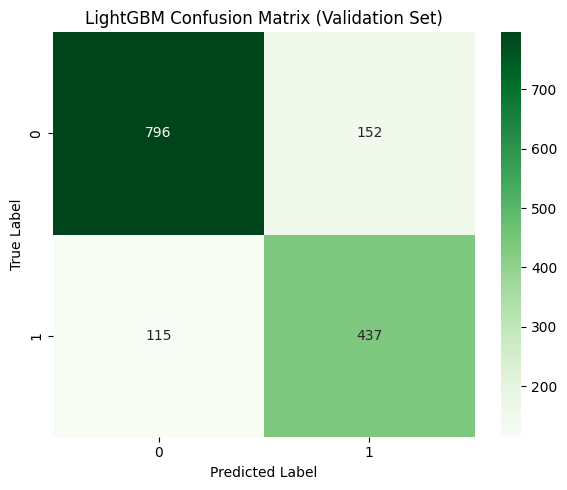

<Figure size 1000x600 with 0 Axes>

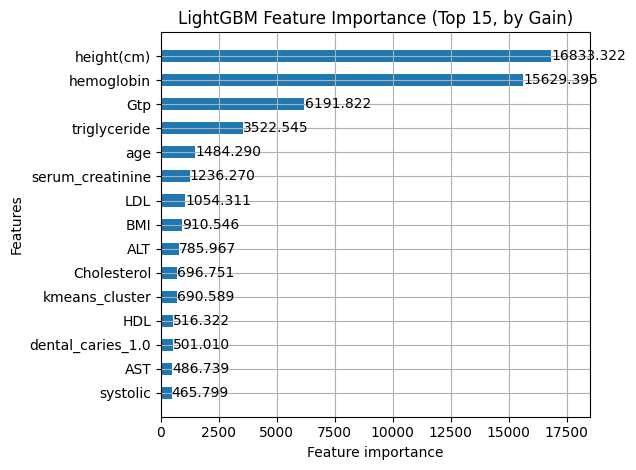

 96%|=================== | 1434/1500 [00:15<00:00]       

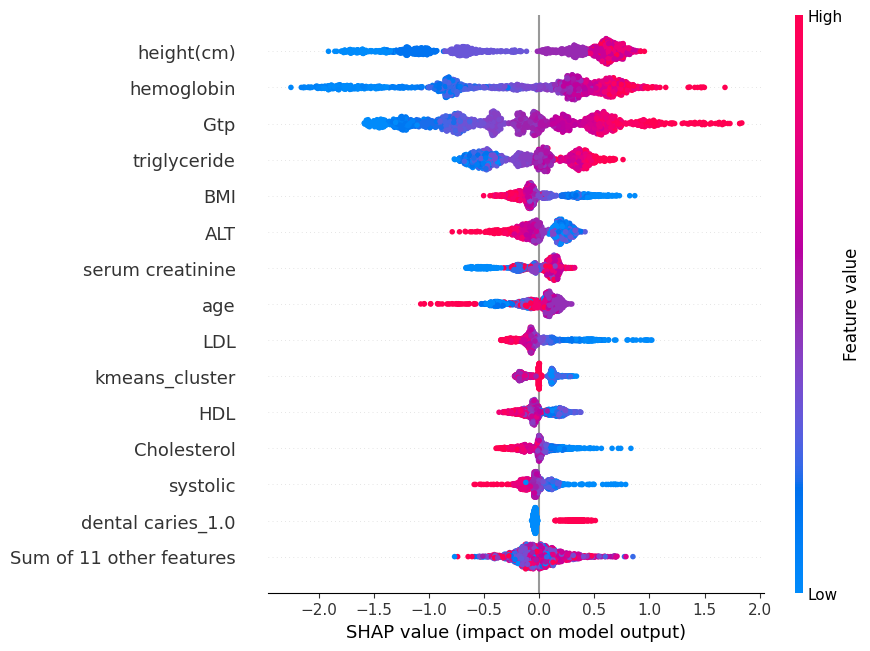

In [44]:
#-----------------------------
# 4. Draw Learning Curve
#-----------------------------
results = best_lgb.evals_result_

plt.figure(figsize=(8, 5))
plt.plot(results['valid_0']['auc'], label='Train AUC')
plt.plot(results['valid_1']['auc'], label='Validation AUC')
plt.xlabel('Boosting Round')
plt.ylabel('AUC Score')
plt.title('LightGBM Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------
# 5. Predict on Validation Set & Confusion Matrix
#-----------------------------
lgb_preds = best_lgb.predict_proba(X_val)
lgb_labels = (lgb_preds[:, 1] >= 0.5).astype(int)

cm = confusion_matrix(y_val, lgb_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LightGBM Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

#-----------------------------
# 6. Feature Importance
#-----------------------------
plt.figure(figsize=(10, 6))
lgb.plot_importance(best_lgb, max_num_features=15, importance_type='gain', height=0.5)
plt.title('LightGBM Feature Importance (Top 15, by Gain)')
plt.tight_layout()
plt.show()

#-----------------------------
# 7. SHAP Analysis
#-----------------------------
explainer = shap.Explainer(best_lgb, X_train, feature_names=X_train.columns)
shap_values = explainer(X_val)

# SHAP Summary Plot
shap.plots.beeswarm(shap_values, max_display=15)

# (Optional) Individual force plot
# shap.plots.force(shap_values[0])


### 5.3 CatBoost 模型優化與訓練

CatBoost 是一種高效能的梯度提升樹實現，尤其擅長處理類別型特徵，並自動處理缺失值。

In [49]:
import optuna
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap

#-----------------------------
# 1. Define Optuna Objective Function
#-----------------------------
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'eval_metric': 'AUC',
        'random_seed': 42,
        'task_type': 'CPU',  # 改為 CPU 以避免 GPU 可能導致的編碼問題
        'od_type': 'Iter',
        'od_wait': 30,
        'verbose': 0
    }

    aucs = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 將 DataFrame 轉換為 numpy 數組，避免字串編碼問題
    X_values = X.values
    y_values = y.values

    for train_idx, val_idx in skf.split(X_values, y_values):
        X_fold_train, X_fold_val = X_values[train_idx], X_values[val_idx]
        y_fold_train, y_fold_val = y_values[train_idx], y_values[val_idx]

        # 使用 Pool 對象處理數據
        train_pool = Pool(X_fold_train, y_fold_train)
        val_pool = Pool(X_fold_val, y_fold_val)

        model = CatBoostClassifier(**params)
        model.fit(
            train_pool, 
            eval_set=val_pool,
            use_best_model=True,
            verbose=False
        )

        preds = model.predict_proba(X_fold_val)[:, 1]
        auc = roc_auc_score(y_fold_val, preds)
        aucs.append(auc)

    mean_auc = np.mean(aucs)
    return mean_auc

#-----------------------------
# 2. Run Optuna Optimization
#-----------------------------
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=30)

print("Best CatBoost Parameters:")
print(study_cat.best_params)
print(f"Best AUC: {study_cat.best_value:.4f}")

#-----------------------------
# 3. Train Final Model with Best Parameters
#-----------------------------
best_cat = CatBoostClassifier(
    **study_cat.best_params,
    eval_metric='AUC',
    task_type='CPU',
    random_seed=42,
    use_best_model=True,
    verbose=False
)

best_cat.fit(X, y, eval_set=(X_val, y_val))



[I 2025-04-14 16:58:04,590] A new study created in memory with name: no-name-cf51be3f-2415-4c71-b449-fd210045e565
[I 2025-04-14 16:58:36,179] Trial 0 finished with value: 0.8807509163194404 and parameters: {'iterations': 461, 'learning_rate': 0.1541839654932359, 'depth': 9, 'l2_leaf_reg': 1.8142878904295885, 'bagging_temperature': 0.6881639301635573, 'border_count': 224}. Best is trial 0 with value: 0.8807509163194404.
[I 2025-04-14 16:59:02,562] Trial 1 finished with value: 0.8841678625580535 and parameters: {'iterations': 475, 'learning_rate': 0.11731187333649278, 'depth': 7, 'l2_leaf_reg': 8.901553433202142, 'bagging_temperature': 0.5720587425689969, 'border_count': 139}. Best is trial 1 with value: 0.8841678625580535.
[I 2025-04-14 16:59:27,327] Trial 2 finished with value: 0.8845526809059325 and parameters: {'iterations': 202, 'learning_rate': 0.13280443519459936, 'depth': 5, 'l2_leaf_reg': 7.811880351931005, 'bagging_temperature': 0.3892220836312018, 'border_count': 44}. Best is 

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xad in position 13: invalid start byte

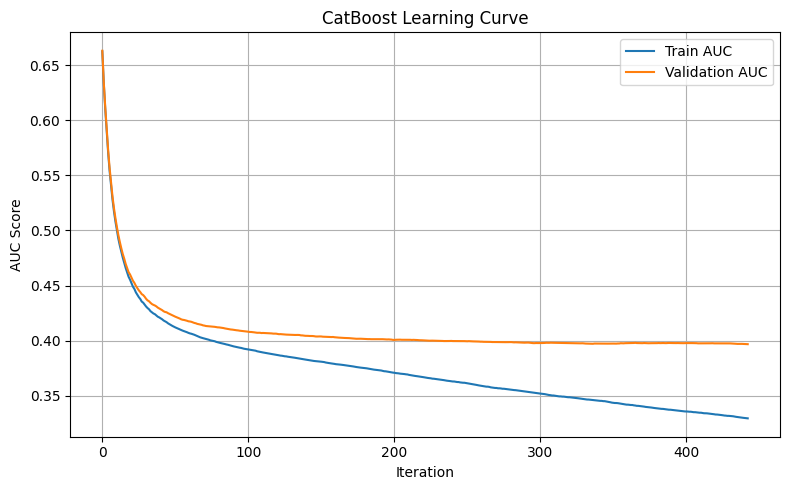

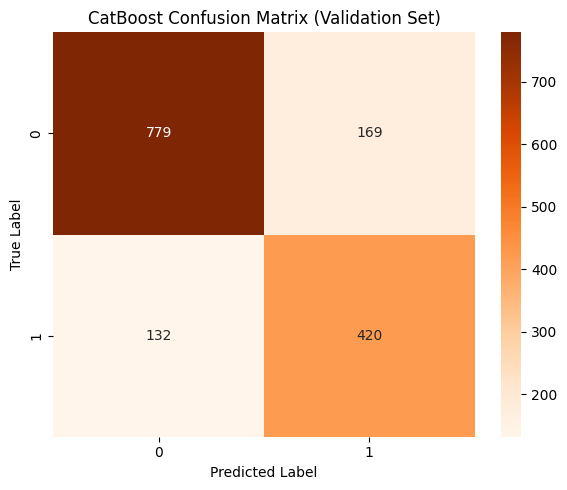

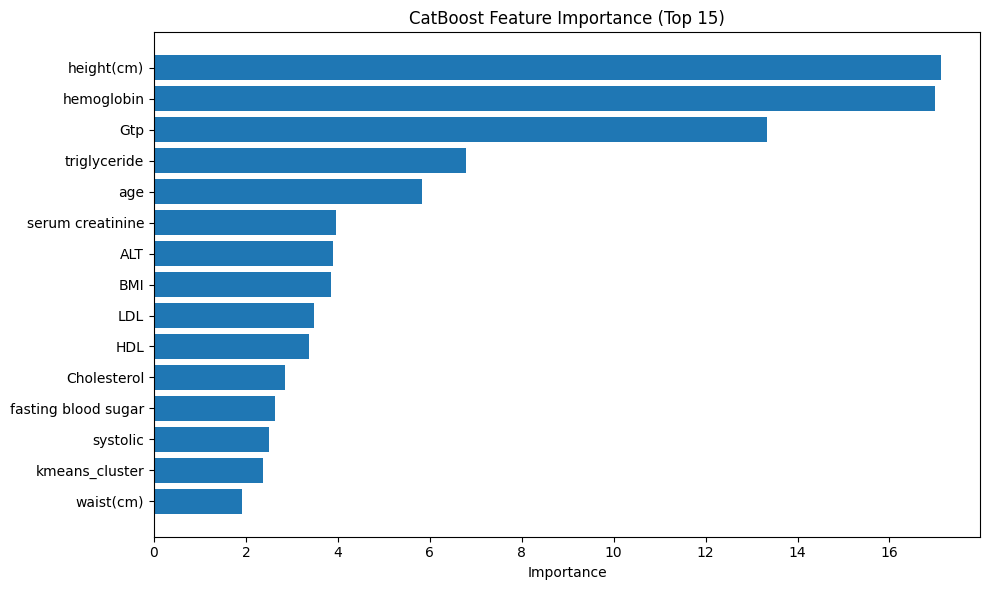

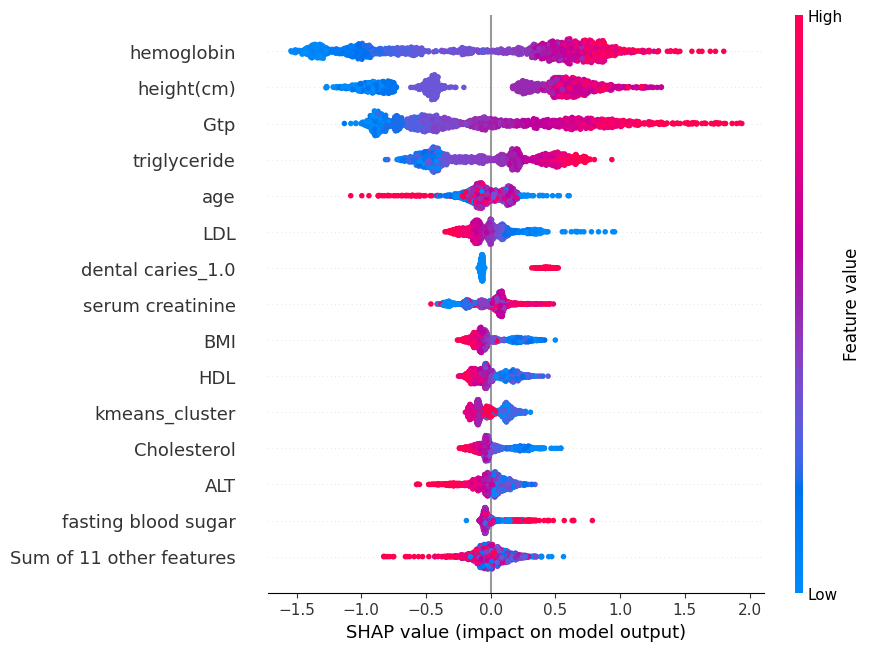

In [ ]:
#-----------------------------
# 4. Draw Learning Curve
#-----------------------------
cat_log = best_cat.get_evals_result()
train_auc = cat_log['learn']['Logloss']
val_auc = cat_log['validation']['Logloss']

plt.figure(figsize=(8, 5))
plt.plot(train_auc, label='Train AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xlabel('Iteration')
plt.ylabel('AUC Score')
plt.title('CatBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------
# 5. Predict & Confusion Matrix
#-----------------------------
cat_preds = best_cat.predict_proba(X_val)[:, 1]
cat_labels = (cat_preds >= 0.5).astype(int)

cm = confusion_matrix(y_val, cat_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CatBoost Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

#-----------------------------
# 6. Feature Importance
#-----------------------------
plt.figure(figsize=(10, 6))
feat_importance = best_cat.get_feature_importance(prettified=True)
feat_importance_top = feat_importance.sort_values(by='Importances', ascending=False).head(15)

plt.barh(feat_importance_top['Feature Id'], feat_importance_top['Importances'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('CatBoost Feature Importance (Top 15)')
plt.tight_layout()
plt.show()

#-----------------------------
# 7. SHAP Summary Plot
#-----------------------------
explainer = shap.Explainer(best_cat)
shap_values = explainer(X_val)

# Summary plot
shap.plots.beeswarm(shap_values, max_display=15)

# (Optional) Individual force plot
# shap.plots.force(shap_values[0])


## 6. 模型集成與預測

在這部分，我們將根據各個模型在驗證集上的 AUC 表現，進行自動加權集成，結合三個模型的預測結果。

In [52]:
xgb_preds = best_xgb.predict_proba(X_test)
lgb_preds = best_lgb.predict_proba(X_test)
cat_preds = best_cat.predict_proba(X_test)

In [54]:
# 進行模型融合
#final_preds = 0.34 * xgb_preds + 0.33* lgb_preds + 0.33 * cat_preds
final_preds = 0.5 * xgb_preds + 0.5* lgb_preds
# 生成提交檔案
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'submission_{timestamp}.csv'
sample_submission['smoking'] = final_preds
sample_submission.to_csv(filename, index=False)
print(f"提交檔案已儲存為 {filename}")

提交檔案已儲存為 submission_20250414_172218.csv
